# Module 2, Section 1: Establishing Baseline with Offline Evaluation

We now have an MVP customer support agent for TechHub that can answer questions about orders, provide product information, and explain store policies. But before we can put it infront of customers, we first need build up confidence that it does the things we expect it to do.

Throughout this module, we'll learn how to run offline evaluations to establish baseline performance and then systematically improve our agent with evaluation driven development (EDD).

**What is offline evaluation?**

Evaluation is a crucial, ongoing process that allows us to quantitatively measure how well our application is working, identify areas for improvement, and reliably evolve our system over time.

<div align="center">
    <img src="../../static/offline_eval_process.png">
</div>

The offline evaluation process is comprised of a few components:

1. Dataset - a curated set of representative examples, where each example includes:
    - an input to the system
    - a ground truth (reference) output that demonstrates what the expected, high quality outcome should look like
2. Application - the LLM system that we intend to evaluate. We feed it our example inputs, and collect the system's actual output.
3. Evaluators - functions that quantify some aspect of performance by comparing the inputs, outputs, and reference outputs


**What makes a good eval setup?**

When beginning to create a new eval suite, it's often best to:

- Gather a small set of labeled examples that are representative of your system's core functionality and scenarios it should handle.
- Lean on domain expertise to ensure the examples are representative and accurate.
- Select only a few, simple metrics. In practice, binary evaluation metrics force clearer thinking, more consistent labeling, and are easier/faster to interpret when analyzing and iterating on your system.
Stfarting with a large sample and/or many, complex metrics makes it harder to inspect and deeply understand system behavior, which quickly leads to analysis paralysis.

Let's see how we can perform offline evaluation on our TechHub agent in LangSmith to establish the baseline performance!

#### Setup


In [1]:
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

True

## 1. Curate a set of representative examples

In our use case, we've teamed up with the TechHub customer support team to create 10 ground truth examples. Each example has:

- **inputs**: A customers question
- **outputs**: The expected correct answer (i.e. ground truth)
- **metadata**: A category that the customer support team uses to bucket question types

This dataset structure allows us to evaluate the "end-to-end" nature of our agent - commonly referred to as [final answer evaluation](https://docs.langchain.com/langsmith/evaluation-approaches#evaluating-an-agent%E2%80%99s-final-response).

Let's load and explore the dataset:

In [2]:
import json
from pathlib import Path
from pprint import pprint

# Load the dataset from JSON
dataset_path = Path("datasets/new_baseline_dataset.json")

with open(dataset_path, "r") as f:
    examples = json.load(f)

In [3]:
pprint(examples[0])

{'inputs': {'question': 'How much have I spent on keyboards in total? My email '
                        'is it.purchasing@finance.com'},
 'metadata': {'category': 'account_summary', 'example_number': 1},
 'outputs': {'answer': 'You have spent $1,118.00 on keyboards across all your '
                       'orders.'}}


## 2. Create a dataset in LangSmith

Note that we convert the examples into `messages` format so that its natively stored in LangSmith with the structure needed to use these examples when invoking our agent.

In [4]:
from langsmith import Client

client = Client()

dataset_name = "techhub-baseline-evaluation"
dataset_description = (
    "Representative customer support questions curated by our support team"
)

if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(
        dataset_name=dataset_name,
        description=dataset_description,
    )

    client.create_examples(
        dataset_id=dataset.id,
        inputs=[
            {"messages": [{"role": "user", "content": ex["inputs"]["question"]}]}
            for ex in examples
        ],
        outputs=[
            {"messages": [{"role": "assistant", "content": ex["outputs"]["answer"]}]}
            for ex in examples
        ],
        metadata=[ex["metadata"] for ex in examples],
    )
else:
    dataset = next(client.list_datasets(dataset_name=dataset_name))

print(f"Dataset in LangSmith: {dataset.url}")

Dataset in LangSmith: https://smith.langchain.com/o/5aa54808-d164-4ed7-bc4d-e5630f7ffd37/datasets/8a1d4378-6f53-43d4-bae3-5bbba3d3c03b


In [5]:
# client.delete_dataset(dataset_id=dataset.id)

## 3. Initialize the agent we want to evaluate

Here we'll use the the supervisor agent with HITL verification that we built in Section 4 of Module 1.

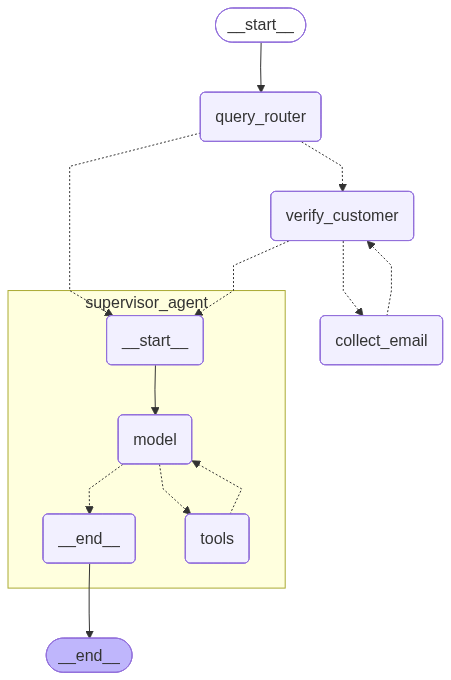

In [6]:
from IPython.display import Image
from agents.supervisor_hitl_agent import create_supervisor_hitl_agent

agent = create_supervisor_hitl_agent()

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
import uuid
from config import get_techhub_runtime_context

thread_id = uuid.uuid4()
config = {"configurable": {"thread_id": thread_id}}
runtime_context = get_techhub_runtime_context(with_vectorstore=True)

t = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "How much have I spent on keyboards in total? My email is it.purchasing@finance.com",
            }
        ]
    },
    config=config,
    context=runtime_context,
)

/Users/andrew.reed/Documents/workshops/lc-enablement-workshop/.venv/lib/python3.13/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='context', input_value=RuntimeContext(db=<langch..., policy_retriever=None), input_type=RuntimeContext])
  return self.__pydantic_serializer__.to_python(


In [11]:
t["messages"][-1].pretty_print()

================================== Ai Message ==================================

Based on your order history, **you've spent a total of $1,118.00 on keyboards** at TechHub.

Here's the breakdown across your orders:
- **ORD-2024-0070:** $237.00
- **ORD-2024-0066:** $297.00
- **ORD-2024-0048:** $78.00
- **ORD-2023-0009:** $506.00

Is there anything else you'd like to know about your purchases or our keyboard products?


## 4. Define our evaluators

Evaluators are functions that score how well your application performs on a particular example.

We'll start out with two simple evaluators: `correctness` and `total_tool_calls`

### Evaluator #1: Correctness

An evaluator that uses LLM-as-a-Judge to determine if the agent's output is "correct" when comparing it against the reference output (i.e. ground truth output)

In [12]:
from pydantic import BaseModel, Field
from langchain.chat_models import init_chat_model
from config import DEFAULT_MODEL


CORRECTNESS_PROMPT = """You are an expert data labeler evaluating model outputs for correctness.

Your task is to assign a boolean score based on the following rubric:

<Rubric>
  A correct answer (True):
  - Provides accurate and complete information
  - Contains no factual errors
  - Addresses all parts of the question
  - Is logically consistent
</Rubric>

<Instructions>
  - Carefully read the input and output
  - Compare the output to the reference_output
  - Check for factual accuracy and completeness
  - Focus on correctness of information rather than style or verbosity differences
  - It's ok if the ouput provides additional information that is not directly included in the reference output
  - Return a boolean score (True if correct, False if incorrect), not a string
</Instructions>

<input>
{inputs}
</input>

<output>
{outputs}
</output>

<reference_outputs>
{reference_outputs}
</reference_outputs>
"""


# For structured LLM output
class CorrectnessScore(BaseModel):
    reasoning: str = Field(..., description="A concise reasoning for the score")
    score: bool = Field(
        ..., description="True if the output is correct, False if incorrect."
    )


# Create a structured LLM
correctness_evaluator_llm = init_chat_model(model=DEFAULT_MODEL).with_structured_output(
    CorrectnessScore
)


# Define the evaluator function
def correctness_evaluator(inputs: dict, outputs: dict, reference_outputs: dict) -> dict:
    """Evaluate the correctness of the output against the reference output."""

    formatted_prompt = CORRECTNESS_PROMPT.format(
        inputs=inputs, outputs=outputs, reference_outputs=reference_outputs
    )

    eval_result = correctness_evaluator_llm.invoke(formatted_prompt)

    # return a dictionary with the format the evaluator expects
    return {
        "key": "correctness",
        "score": eval_result.score,
        "comment": eval_result.reasoning,
    }

#### Target Function

A target function is used to specify how `inputs` from our dataset are processed to produce `outputs` that we want to evaluate. In this case, its simply just running the `inputs` through our agent to produce a response message.

In [25]:
import uuid


def target_function(inputs: dict) -> dict:
    """Target function that runs our agent to get outputs for evaluation."""

    thread_id = uuid.uuid4()
    config = {"configurable": {"thread_id": thread_id}}

    result = agent.invoke(
        inputs,
        config=config,
        context=runtime_context,
    )

    return {
        "messages": [{"role": "assistant", "content": result["messages"][-1].content}]
    }

Now, let's test the `correctness` evaluator on a single example from our dataset to see how everything works

In [14]:
# get an example from our dataset
example = next(
    client.list_examples(dataset_id=dataset.id, metadata={"example_number": 1})
)
pprint(example.inputs)

{'messages': [{'content': 'How much have I spent on keyboards in total? My '
                          'email is it.purchasing@finance.com',
               'role': 'user'}]}


In [15]:
# run the example inputs through our target function
output = target_function(example.inputs)
pprint(output)

/Users/andrew.reed/Documents/workshops/lc-enablement-workshop/.venv/lib/python3.13/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='context', input_value=RuntimeContext(db=<langch..., policy_retriever=None), input_type=RuntimeContext])
  return self.__pydantic_serializer__.to_python(


{'messages': [{'content': "Based on your order history, **you've spent a total "
                          'of $1,118.00 on keyboards** across 4 orders.\n'
                          '\n'
                          "Here's the breakdown:\n"
                          '- **Order ORD-2024-0070**: $237.00 (1× TECH-KEY-015 '
                          '+ 2× TECH-KEY-014)\n'
                          '- **Order ORD-2024-0066**: $297.00 (3× '
                          'TECH-KEY-014)\n'
                          '- **Order ORD-2024-0048**: $78.00 (2× '
                          'TECH-KEY-015)\n'
                          '- **Order ORD-2023-0009**: $506.00 (1× TECH-KEY-012 '
                          '+ 3× TECH-KEY-011)\n'
                          '\n'
                          "Is there anything else you'd like to know about "
                          'your keyboard purchases or your account?',
               'role': 'assistant'}]}


In [16]:
# score the agent output against the reference output
correctness_score = correctness_evaluator(
    inputs=example.inputs, outputs=output, reference_outputs=example.outputs
)
pprint(correctness_score)

{'comment': 'The output provides the correct total amount spent on keyboards '
            '($1,118.00) which matches the reference output. While the output '
            'is more detailed and comprehensive than the reference (including '
            'order breakdown and individual order numbers), it contains all '
            'the accurate information from the reference and adds helpful '
            'context. The core factual claim - that the user spent $1,118.00 '
            'on keyboards - is correct and the additional breakdown supports '
            'this total. There are no factual errors, and the answer addresses '
            "the user's question completely.",
 'key': 'correctness',
 'score': True}


### Evaluator #2: Total Tool Calls

An evaluator that doesn't rely on a ground truth reference, but is a good thing to track as it can help reveal agent patterns and highlight inefficiences

In [17]:
from langsmith.schemas import Run


def count_total_tool_calls_evaluator(run: Run) -> dict:
    """
    Count total tool calls across the entire run (supervisor + sub-agents).

    Returns a single 'score' metric with the total count.
    Use for tracking efficiency: fewer calls = more efficient.
    """

    def traverse_runs(run_obj: Run) -> int:
        """Recursively count all tool-type runs in the tree."""
        count = 0

        # Count this run if it's a tool execution
        if run_obj.run_type == "tool":
            count = 1

        # Recursively count child runs
        if hasattr(run_obj, "child_runs") and run_obj.child_runs:
            for child in run_obj.child_runs:
                count += traverse_runs(child)

        return count

    total_tools = traverse_runs(run)

    return {"key": "total_tool_calls", "score": total_tools}

This evaluator doesn't depend on reference outputs to produce a score, but rather uses metadata from the target function's execution on a given example. This is flexibly handled in the LangSmith SDK by passing a `Run` object as input to the evaluator.

Let's walk through an example to make this clear.

In [18]:
# get a recent sample run from our project
runs = client.list_runs(
    project_name="lc-enablement-workshop",  # Your project
    is_root=True,  # Only root spans (not nested tools)
    limit=1,
)
run = next(runs)

# Fetch the complete run with all children
full_run = client.read_run(run.id, load_child_runs=True)

In [19]:
# we can inspect the full run metadata
vars(full_run)

{'id': UUID('d51b497e-b046-4433-b2d2-99d2ed57644d'),
 'name': 'RunnableSequence',
 'start_time': datetime.datetime(2025, 11, 5, 18, 37, 21, 318971),
 'run_type': 'chain',
 'end_time': datetime.datetime(2025, 11, 5, 18, 37, 23, 857956),
 'extra': {'metadata': {'LANGSMITH_ENDPOINT': 'https://api.smith.langchain.com',
   'LANGSMITH_PROJECT': 'lc-enablement-workshop',
   'LANGSMITH_TRACING': 'true',
   'ls_run_depth': 0,
   'revision_id': 'ccd3a66-dirty'},
  'runtime': {'langchain_core_version': '1.0.1',
   'langchain_version': '1.0.1',
   'library': 'langchain-core',
   'library_version': '1.0.1',
   'platform': 'macOS-15.7.1-arm64-arm-64bit-Mach-O',
   'py_implementation': 'CPython',
   'runtime': 'python',
   'runtime_version': '3.13.7',
   'sdk': 'langsmith-py',
   'sdk_version': '0.4.38'}},
 'error': None,
 'serialized': None,
 'events': [{'name': 'start', 'time': '2025-11-05T18:37:21.318971+00:00'},
  {'name': 'end', 'time': '2025-11-05T18:37:23.857956+00:00'}],
 'inputs': {'input': 

In [20]:
# now lets pass the run to our evaluator
count_total_tool_calls_evaluator(full_run)

{'key': 'total_tool_calls', 'score': 0}

## 5. Run an experiment on the full dataset

Now we can use our target_function and two evaluators to programatically run an offline evaluation over each example in our dataset - this is called an experiment in LangSmith.

In [26]:
results = client.evaluate(
    target_function,
    data=dataset_name,
    evaluators=[correctness_evaluator, count_total_tool_calls_evaluator],
    experiment_prefix="baseline-eval",
    description="Evaluate the final answer and total tool calls of our agent on the baseline dataset",
    max_concurrency=5,
)

View the evaluation results for experiment: 'baseline-eval-c9e81ff0' at:
https://smith.langchain.com/o/5aa54808-d164-4ed7-bc4d-e5630f7ffd37/datasets/8a1d4378-6f53-43d4-bae3-5bbba3d3c03b/compare?selectedSessions=5ec81efe-21e2-4ac0-b0d2-44c0d1f640a7




0it [00:00, ?it/s]

/Users/andrew.reed/Documents/workshops/lc-enablement-workshop/.venv/lib/python3.13/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='context', input_value=RuntimeContext(db=<langch...mbda> at 0x1454aae80>})), input_type=RuntimeContext])
  return self.__pydantic_serializer__.to_python(


## 6. Error Analysis in LangSmith UI

Now let's analyze our baseline performance in the LangSmith UI via the link above.


### Navigate to LangSmith for Detailed Analysis

The real power comes from analyzing results in the LangSmith UI:

**Step 1: Find Your Experiment**
1. Go to _LangSmith Datasets & Experiments_
2. Find your experiment: `baseline-mvp-XXXXX`

**Step 2: Review Aggregate Metrics**
- Overall correctness score
- Tool call count distribution
- Success vs failure breakdown

**Step 3: Filter for Failures**
- Click "Add Filter"
- Filter by `correctness == 0.0`
- See which queries failed

**Step 4: Inspect Traces**
- Click into failed examples
- View the full execution trace
- See which tools were called
- Understand why the agent couldn't answer

**Step 5: Identify Patterns**
- Group by metadata category
- Look for common failure types
- Identify root cause